In [10]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os, sys
import healpy as hp
import numpy as np
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib import rcParams
from tqdm import *
import iminuit
from iminuit import Minuit, describe, Struct
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
import pandas as pd
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord

sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/Modules/")
sys.path.append("/tigress/somalwar/Subhaloes/Subhalos/")
# My Functions
import AssortedFunctions
from AssortedFunctions import myLog
import InverseTransform
import PointSource
import PowerLaw

# Siddharth and Laura's Stuff
import constants_noh as constants
import units

# NPTFit modules
from NPTFit import nptfit # module for performing scan
from NPTFit import create_mask as cm # module for creating the mask
from NPTFit import psf_correction as pc # module for determining the PSF correction
from NPTFit import dnds_analysis
rcParams['font.size'] = 15
rcParams['text.usetex'] = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
nside = 128
emin = 0 
emax = 39
channel = 'b'
Nb = 2
conc = "S"
xsec = 1e-22
marr = [100]
ebins = 2*np.logspace(-1,3,41)[emin:emax+2]
my_iebins = [10,15]
r_bounds = [20, 180]
M_MW = 1.1e12 # [M_s]
mMin = 1e-5*M_MW
mMax = .01*M_MW # [M_s]

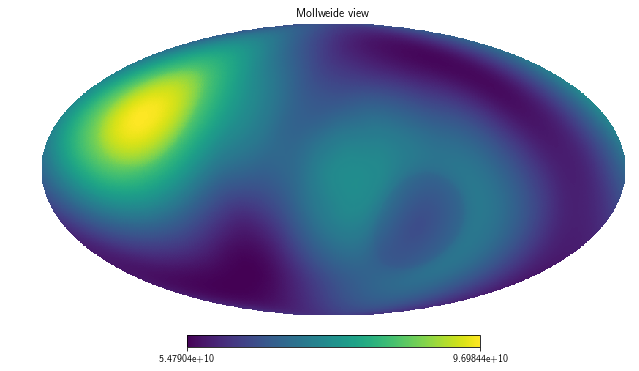

In [3]:
exposure_ebins= []
for ib, b in enumerate(my_iebins[:-1]):
    fermi_exposure = np.zeros(len(np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/maps/exposure0.npy")))
    n = 0
    for bin_ind in range(b, my_iebins[ib+1]):
        n+=1
        fermi_exposure += np.load("/tigress/somalwar/Subhaloes/Subhalos/EnergyBins/maps/exposure"+str(bin_ind)+".npy")
    fermi_exposure = fermi_exposure / n
    exposure_ebins.append(fermi_exposure)
hp.mollview(fermi_exposure)

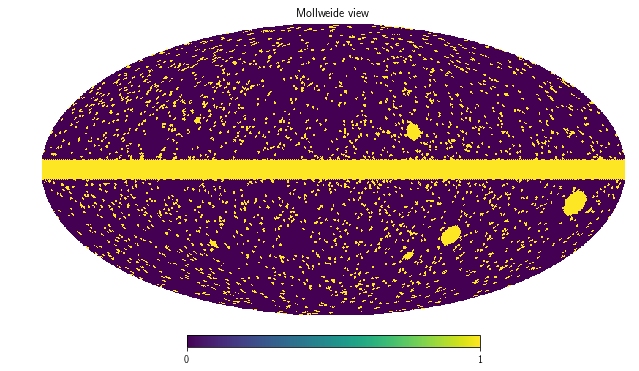

In [4]:
# Setting basic parameters
npix = hp.nside2npix(nside)
   
pscmask=np.array(np.load('/tigress/somalwar/Subhaloes/Subhalos/fermi_data/fermidata_pscmask.npy'), dtype=bool)
mask = cm.make_mask_total(band_mask = True, band_mask_range = 5, mask_ring = False, inner = r_bounds[0], outer = r_bounds[1], custom_mask = pscmask)
#mask = cm.make_mask_total(band_mask = False)
area_rat = (len(mask[~mask]))/len(mask)
hp.mollview(mask)

/tigress/somalwar/anaconda3/lib/python3.6/site-packages/scipy/integrate/quadpack.py:385: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


(1e-13, 1e-09)

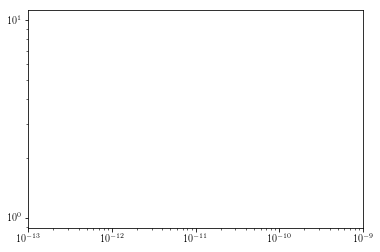

In [5]:
VLSubhalos = np.loadtxt("vltwosubs.txt")
VLSubhalos = VLSubhalos[ np.logical_and(VLSubhalos[:, 5] < mMax, VLSubhalos[:, 5] > mMin) ]

VLSubMass = VLSubhalos[:, 5]
VLSubVMax = VLSubhalos[:, 3]
VLSubRVMax = VLSubhalos[:, 4]
VLSubXYZ = VLSubhalos[:, 7:10]

VLcoords = SkyCoord(x=VLSubXYZ[:, 0], y=VLSubXYZ[:, 1], z=VLSubXYZ[:, 2], unit='kpc', representation_type='cartesian')
VLcoords.representation_type = 'spherical'
VLSubTheta = VLcoords.dec.value * np.pi/180 + np.pi/2
VLSubPhi = VLcoords.ra.value * np.pi/180
#VLSubTheta = (np.arccos(2*np.random.rand(len(VLcoords))-1))
#VLSubPhi = (2*np.pi*np.random.rand(len(VLcoords)))
VLSubR = VLcoords.distance.value
VLPS_set = PointSource.PointSource(VLSubMass, VLSubR, VLSubTheta, VLSubPhi)
VLPS_set.calcJ(conc)

flux_bins = np.logspace(-15, -6, 8*8)

PPnoxsec = VLPS_set.PPnoxsec(marr[0], [ ebins[my_iebins[0]], ebins[my_iebins[1]] ], channel)
VLPS_set.J.value[VLPS_set.J.value*xsec*PPnoxsec*exposure_ebins[ib][VLPS_set.pixels] > 1000] = 0
VLPS_set.J.value[VLPS_set.J.value*xsec*PPnoxsec*exposure_ebins[ib][VLPS_set.pixels] < 1] = 0
F_arr = np.histogram(VLPS_set.J.value[~mask[VLPS_set.pixels]] * xsec * PPnoxsec, bins=flux_bins)[0]
#VLPS_set.J.value[VLPS_set.J.value*xsec*PPnoxsec < 6.24151e2*1.35e-12] = 0
#F_arr = plt.hist(VLPS_set.J.value[VLPS_set.coord.distance.value<400*units.kpc]/6.24151e2 * xsec * PPnoxsec, bins=flux_bins)[0]
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-13, 1e-9)

(array([6.84573258e+09]), array([[3.24638599e+16]]))


Text(0.5,0,'Subhalo Mass [$M_{\\odot}$]')

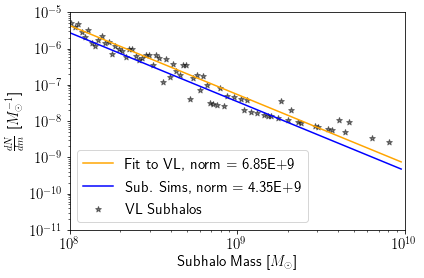

In [116]:
from decimal import Decimal
ydata, xdata = np.histogram(VLSubMass, bins=np.logspace(8, 10, 100))
plt.yscale("log")
plt.xscale("log")

def massfunc(m, A):
    return A*(m)**(-1.9)

plt.scatter((xdata[:-1]+xdata[1:])/2, ydata/np.diff(xdata), c="black", marker="*", label="VL Subhalos", alpha=0.5 )
fit = curve_fit( massfunc, (xdata[:-1]+xdata[1:])/2, ydata/np.diff(xdata) )
print(fit)
plt.plot( xdata[:-1], massfunc(xdata[:-1], fit[0][0]), c="orange", label="Fit to VL, norm = "+"{:.2E}".format(Decimal(fit[0][0])))
plt.plot( xdata[:-1], massfunc(xdata[:-1], 4348124752.852686), c="blue", label="Sub. Sims, norm = "+"{:.2E}".format(Decimal(4348124752.852686)))
plt.legend()
plt.xlim(1e8, 1e10)
plt.ylim(1e-11, 1e-5)
plt.ylabel("$\\frac{dN}{dm}$ [$M_{\odot}^{-1}$]")
plt.xlabel("Subhalo Mass [$M_{\odot}$]")

[1.e+05 1.e+06 1.e+07 1.e+08 1.e+09 1.e+10 1.e+11]


Text(0,0.5,'N$_{det}$')

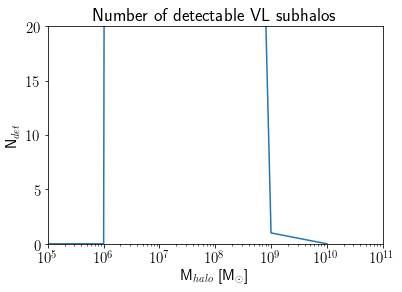

In [65]:
M_arr = np.histogram(VLPS_set.Mvir[np.logical_and(VLPS_set.coord.distance.value<400*units.kpc, VLPS_set.J.value!=0)]/units.M_s, bins=np.logspace(5, 11, 7))
plt.plot(M_arr[1][:-1], M_arr[0])
print(M_arr[1])
plt.xscale("log")
plt.xlim(1e5, 1e11)
plt.ylim(0,20)
plt.title("Number of detectable VL subhalos")
plt.xlabel("M$_{halo}$ [M$_{\odot}$]")
plt.ylabel("N$_{det}$")

/tigress/somalwar/Subhaloes/Subhalos/Modules/AssortedFunctions.py:20: RuntimeWarning: divide by zero encountered in log10
  return np.where( n!=0, np.log10(n), 0);


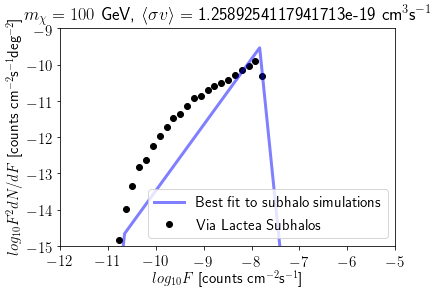

In [66]:
fig = plt.figure()
ax = plt.subplot(111)
dF = np.diff(flux_bins)
dN = F_arr/(4*np.pi*(180/np.pi)**2*area_rat)
F = (np.array(flux_bins)[:-1]+np.array(flux_bins)[1:])/2.
#yerr_up = (AssortedFunctions.PandGErrors(F_arr, True))[1]
#yerr_dn = (AssortedFunctions.PandGErrors(F_arr, True))[0]
#yerr_up = F**2 * yerr_up / dF /(4*np.pi*(180/np.pi)**2*area_rat)
#yerr_dn = F**2 * yerr_dn / dF /(4*np.pi*(180/np.pi)**2*area_rat)
plt.errorbar(myLog(F), myLog(F**2*dN/dF), fmt='o', c="black", label="Via Lactea Subhalos")

best_fit_params = [np.array([-5.376762134762914 , 15.0 , 0.183786868 , -9.99994444 , 999.9987155 , 0.001499989  ])]
F_test = np.logspace(-12,6,5000)
best_fit_params2 = np.array(best_fit_params[0])
best_fit_params2[0] = 10**best_fit_params2[0]
best_fit_params2[-1] = best_fit_params2[-2]*best_fit_params2[-1]
subhalos = np.load('/tigress/somalwar/Subhaloes/Subhalos/MC/EinastoTemplate2.npy')
subhalos = subhalos/np.mean(subhalos)
best_fit_params2 = np.array(best_fit_params2*np.array([np.average(exposure_ebins[ib][~mask]/area_rat/(4*np.pi * (180/np.pi)**2)*np.sum(subhalos[~mask])), 1., 1., 1., 1/np.average(exposure_ebins[ib][~mask]), 1/np.average(exposure_ebins[ib][~mask])]))
best_fit_params2[0] = np.log10(best_fit_params2[0])
best_fit_params2[-2:] = np.log10(best_fit_params2[-2:])
best_fit_params2[-1] = np.abs(best_fit_params2[-2]) + best_fit_params2[-1]
plt.plot(myLog(F_test), 2*myLog(F_test)+PowerLaw.simple_power(myLog(F_test), False, *best_fit_params2), zorder=5, linewidth=3, c="blue", alpha=0.5, label="Best fit to subhalo simulations") #$M_{min}=$1e-5, Broken power Law Fit, Nb = " +str(Nb))


ax.set_xlim(-12, -5)
ax.set_ylim(-15, -9)
ax.set_title("$m_{\chi} = "+str(marr[0])+"$ GeV, $\\langle \sigma v \\rangle =$ "+str(xsec)+" cm$^3$s$^{-1}$")
ax.set_ylabel("$log_{10} F^2dN/dF$ [counts cm$^{-2}$s$^{-1}$deg$^{-2}$]")
ax.set_xlabel("$log_{10} F$ [counts cm$^{-2}$s$^{-1}$]")
ax.legend()

In [52]:
best_fit_params_mask = []
flux_map = np.zeros(hp.nside2npix(nside))
flux = VLPS_set.J.value * xsec * PPnoxsec
for ipix, pix in enumerate(VLPS_set.pixels):
    flux_map[pix] += flux[ipix]
#np.save("/tigress/somalwar/Subhaloes/Subhalos/MC/FixedSCD/subhalo_flux_map_VL_1e-22_2_10-15", flux_map/10.)

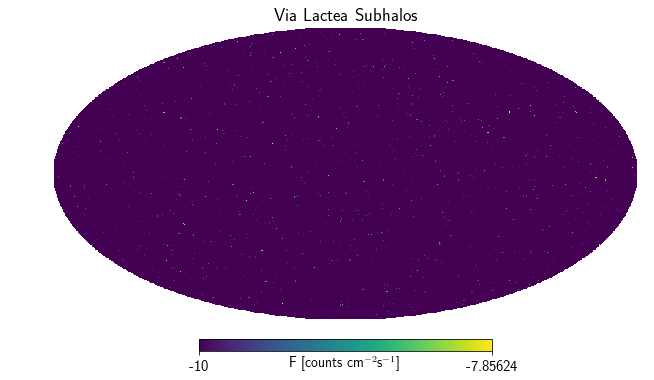

In [184]:
hp.mollview(np.log10(1e-10+flux_map), title="Via Lactea Subhalos", unit=r"F [counts cm$^{-2}$s$^{-1}$]")